# Alchemical free energy calculations

## Overview

"We run alchemical free energy perturbation calculations to calculate the binding free energy of Na+ ions to a transporter protein. Each run consists of O(100) independent simulations for a different value of a parameter lambda.  Each such simulation is called a “window” (because it’s a “windowed” or stratified sampling approach.) **The results need to be analyzed and combined.** We find that convergence is an issue and we would ultimately be able to redirect more resources to “windows” where we detect slow convergence." †

†New opportunities for RADICAL + MD workflows and online analysis: https://docs.google.com/document/d/1xdwn3wn_kqS-1wHw0sFIkAGct7Gk0Ie86Jesf-7smHc/

## Objective

This ipython notebook evaluates the alchemlyb system focusing on parsing multiple files (25,089 files divided by 106 simulations) and building Python Pandas DataFrame for the subsequent analysis. We visualize the function calls below, and provide the results of profiling python functions executed on XSEDE PSC Bridges to investigate performance bottlenecks with the real data (170GB in total)

## Visualization - the simulations for the Na+ ion in water (repulsion_to_ghost)

This demonstrates the process of legs of the ion in water (which is using a small dataset but the same process) where there are functions executed in parallel (`get_dHdl`) and aggregated for TI estimator (`get_TI`), see the image as a bottom-up processing. We see `get_dHdl()` is called multiple times whereas `get_TI()` is called once but we need to verify that which step takes most of time. [Full size image is here](repulsion_to_ghost.png). The data to be processed in the **Complex + ion** has a large number of files which are too large to display here but the profiling used this large dataset.

In [1]:
import plotly
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
%matplotlib inline

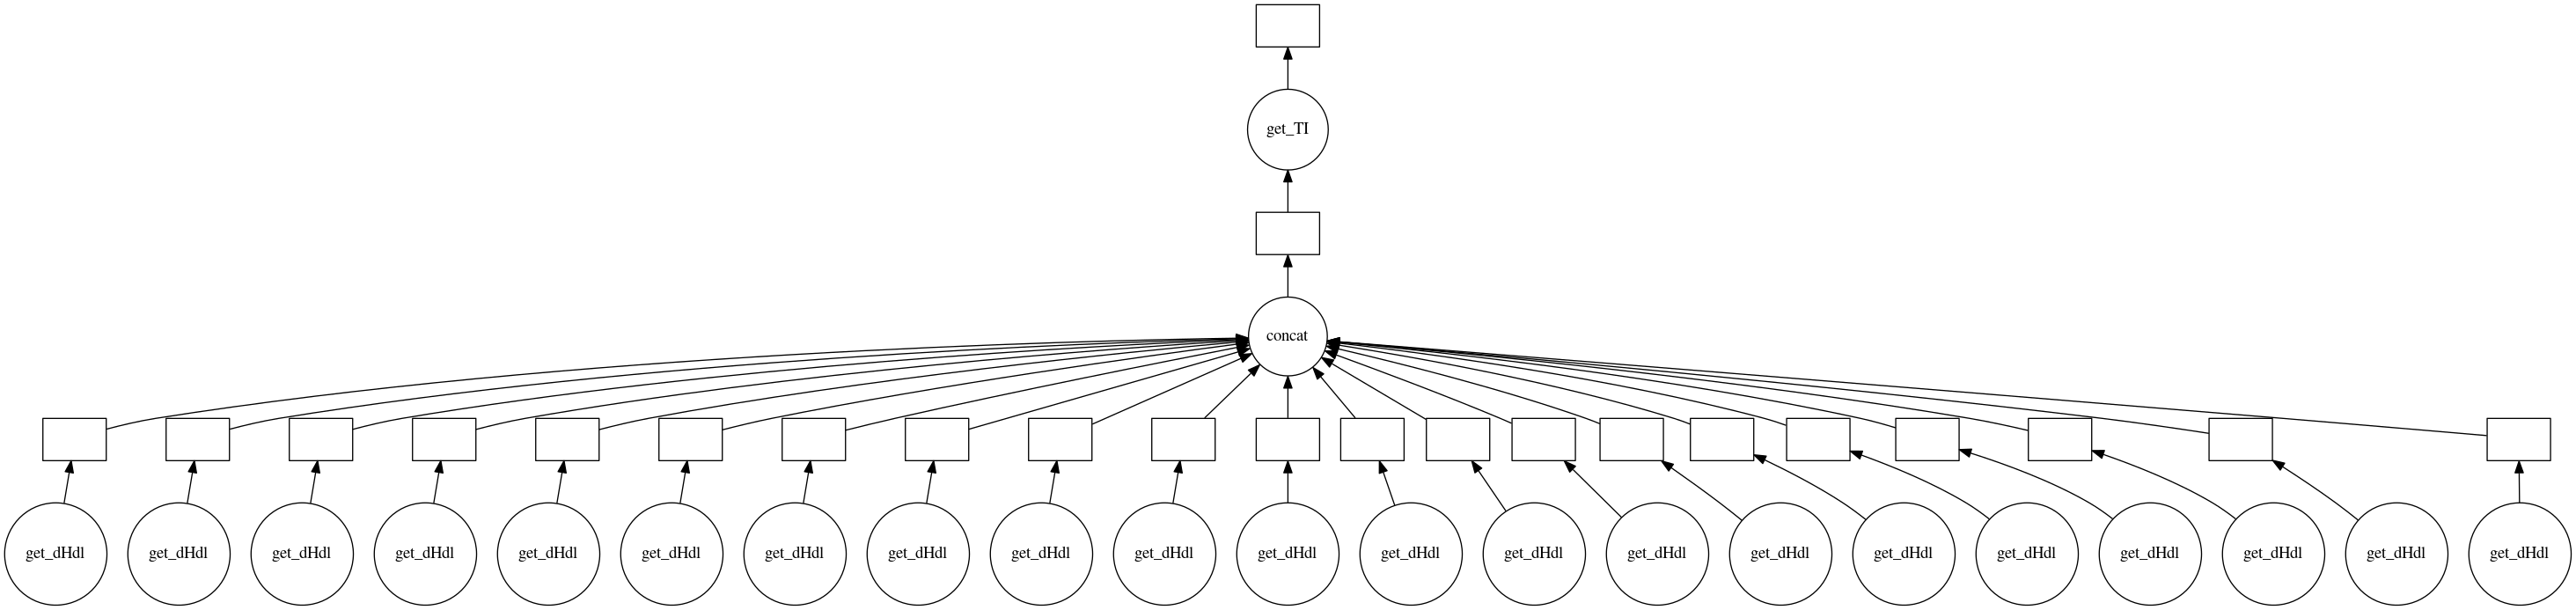

In [2]:
from IPython.display import Image
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))
Image(filename='repulsion_to_ghost.png') 

get_dHdl() returns a Dataframe, pandas.concat() concatenates the pandas objects and provide to the TI estimator of alchemlyb. Time complexity is `O(n^2)` where `x` number of sims have `y` windows. [Full size image is here](repulsion_to_ghost.png).

## First Run on PSC Bridges

The test run is using [the three main functions](https://github.com/hpcanalytics/midas-alchemlyb/blob/master/analysis.ipynb) but dask distrubted is not applied. With the given data, it took 3 hours 23 minutes to complete on a single node (28 cores by two Intel(R) Xeon(R) CPU E5-2695 v3 @ 2.30GHz, and 128GB RAM). This was done with the secondary binding site, S2 IF where sim files are stored on pylon5 shared Lustre filesystem.

```hrlee 5010882 analysis.nodask.sh RM  COMPLETED   09:00:00 2019-03-01T11:59:55 2019-03-01T15:22:46   ``` **```03:22:51```** ``` 1 28 r191 ```

With Dask, it is reduced to 33.5 minutes.

### Profiling Script - line by line

To understand the 3 hours and 23 minutes in detail, I ran Python [line_profiler](https://github.com/rkern/line_profiler) which helps us to step through code, provides a breakdown of execution time per code line. This was done to identify a hot spot of the script and **`extract_dHdl()`** is where most time is spent. A quick recap of the script is that the functions build a data strucuture of sim directories using [mdsynthesis](https://github.com/datreant/MDSynthesis) and invoke 1) `get_dHdl()` with sims over groups of $\lambda$ windows, 2) read GROMACS simulation files (.xvg) and construct Pandas DataFrame by `get_dHdl_XVG()` and 3) call get_TI() as it is described in the diagram above. The high proportion of the script time occurs at line 45 where `extract_dHdl() from alchemlyb.parsing.gmx` is called in the `get_dHdl_XVG()`, if you are interested in the profiling details below, 93.3% Time. This makes sense because we have 25,089 xvg files to read.
```
(alchemlyb) [hrlee@login005 ~]$ python -m line_profiler analysis.nodask.py.lprof 
...
Total time: 15311.5 s
File: analysis.nodask.py
Function: get_dHdl_XVG at line 41

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    41                                           @profile
    42                                           def get_dHdl_XVG(sim, lower=None, upper=None, step=None):
    43       106         97.0      0.9      0.0      dHdls = []
    44     25195  811628590.0  32213.9      5.3      for xvg in sim['WORK/dhdl/'].glob('*.xvg'):
```

**```    45     25089 14280714799.0 569202.2     93.3          dHdls.append(extract_dHdl(xvg.abspath, T=T))```**

```
    46       106  178900779.0 1687743.2      1.2      return slicing(pd.concat(dHdls).sort_index(0), 
    47       106        202.0      1.9      0.0                     lower=lower, 
    48       106         57.0      0.5      0.0                     upper=upper, 
    49       106   40263036.0 379840.0      0.3                     step=step)

Total time: 15312.3 s
File: analysis.nodask.py
Function: get_dHdl at line 52

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    52                                           @profile
    53                                           def get_dHdl(sim, lower=None, upper=None, step=None):
    54       106         64.0      0.6      0.0      try:
    55       106     144936.0   1367.3      0.0          dHdl = sim.data.retrieve('dHdl')
    56                                                   if dHdl is None:
    57                                                       dHdl = get_dHdl_XVG(sim, lower=lower, upper=upper, step=step)
    58                                                   dHdl = slicing(dHdl.sort_index(0), 
    59                                                                  lower=lower, 
    60                                                                  upper=upper, 
    61                                                                  step=step)
    62       106        159.0      1.5      0.0      except:
    63                                                   # THIS WILL NOT STORE THE VALUE FOR LATER USE SO YOU SHOULD REALLY
    64                                                   # CONTINUOUSLY UPDATE THE dHdl DATA IN THE SIMS
```

**```       
    65       106 15312112756.0 144453893.9    100.0          dHdl = get_dHdl_XVG(sim, lower=lower, upper=upper, step=step)```**
```
    66       106        195.0      1.8      0.0      return dHdl

...

```

For the full output message of the profiling is available here: https://github.com/hpcanalytics/midas-alchemlyb/blob/master/analysis.nodask.lprof.txt

### Processing Time per File

Now we understand which function we need to optimize, `extract_dHdl()` to reduce entire processing time. We will take a close look of the function later, but it is also important to confirm **if the execution time does directly depend on the file size**. The result indicates that the median of elapsed time of processing a file is 0.22 second where the median file size is 2.75MB and the mean value of processing throughput is **14.27 MB/s**. The logged data is represented below and the full log file is available here: [get_dHdl_XVG.nodask.log](https://github.com/hpcanalytics/midas-alchemlyb/blob/master/get_dHdl_XVG.nodask.log)

In [3]:
df = pd.read_csv(open("get_dHdl_XVG.nodask.log"), sep=",",quotechar = '\'')
df = df.sort_values(by=['sim','filename']).reset_index(drop=True)
# 99.73%
df_outlier_removed = df[~(np.abs(df.bytes-df.bytes.mean()) > (3*df.bytes.std()))]
df_outlier_removed = df_outlier_removed.assign(mbytes=df_outlier_removed['bytes']/2**20)

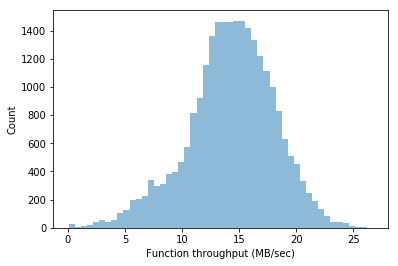

In [4]:
ax = (df_outlier_removed['throughput (byte/sec)']/2**20).plot.hist(alpha=0.5, bins=50)
ax.set_xlabel("Function throughput (MB/sec)")
ax.set_ylabel("Count")

In [5]:
df # Note that elapsed_time is in second

,func,type,sim,filename,throughput (byte/sec),elapsed_time,bytes
0,get_dHdl_XVG,loop,rep2repghost_state_0_x1,dhdl.part0001.xvg,5.296401e+06,0.514906,2727147
1,get_dHdl_XVG,loop,rep2repghost_state_0_x1,dhdl.part0002.xvg,1.981514e+07,0.569301,11280782
2,get_dHdl_XVG,loop,rep2repghost_state_0_x1,dhdl.part0003.xvg,1.002758e+07,0.192652,1931833
3,get_dHdl_XVG,loop,rep2repghost_state_0_x1,dhdl.part0004.xvg,1.382270e+07,0.140323,1939639
4,get_dHdl_XVG,loop,rep2repghost_state_0_x1,dhdl.part0005.xvg,1.325725e+07,0.146186,1938020
5,get_dHdl_XVG,loop,rep2repghost_state_0_x1,dhdl.part0006.xvg,1.271237e+07,0.152441,1937890
6,get_dHdl_XVG,loop,rep2repghost_state_0_x1,dhdl.part0007.xvg,1.506960e+07,0.918430,13840373
7,get_dHdl_XVG,loop,rep2repghost_state_0_x1,dhdl.part0008.xvg,1.514642e+07,0.184267,2790990
8,get_dHdl_XVG,loop,rep2repghost_state_0_x1,dhdl.part0009.xvg,9.069784e+06,0.120515,1093046
9,get_dHdl_XVG,loop,rep2repghost_state_0_x1,dhdl.part0010.xvg,1.495524e+07,0.183698,2747246


### Throughput by File Sizes `(<1MB, 1-10MB, >10MB)`

The boxplot below indicates that dealing with lots of small files has a large impact on the performance as the throughput is improved with larger files. The second scatter plot is a same representation of the throughput as a function of file sizes.

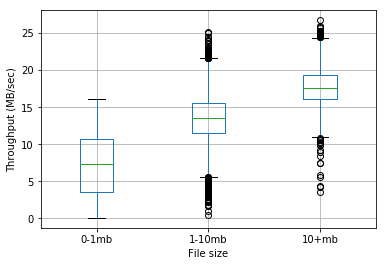

In [6]:
df_1mb = df_outlier_removed[df_outlier_removed['bytes'] < 2**20 ]
df_10mb = df_outlier_removed[(df_outlier_removed['bytes'] >= 2**20) & (df_outlier_removed['bytes'] < 2**20*10) ]
df_10mb_over = df_outlier_removed[(df_outlier_removed['bytes'] >= 2**20*10) ]
sizes = pd.concat([df_1mb['throughput (byte/sec)'].reset_index(drop=True), df_10mb['throughput (byte/sec)'].reset_index(drop=True), df_10mb_over['throughput (byte/sec)'].reset_index(drop=True)], axis=1)
# Byte to MB
sizes = sizes/2**20
sizes.columns = ['0-1mb', '1-10mb', '10+mb']
ax=sizes.boxplot()
ax.set_xlabel("File size")
ax.set_ylabel("Throughput (MB/sec)")

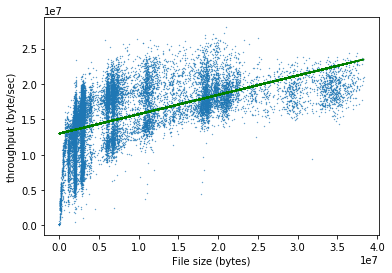

In [7]:
from numpy.polynomial.polynomial import polyfit
b, m = polyfit(df_outlier_removed.bytes, df_outlier_removed['throughput (byte/sec)'], 1)
ax= df_outlier_removed.plot.scatter(x='bytes',y='throughput (byte/sec)',s=.1)
ax.plot(df_outlier_removed.bytes, b + m * df_outlier_removed.bytes , '-', color='green')
ax.set_xlabel('File size (bytes)')

## Conclusion

Improving small file performance is a challenging task in a distributed file system, e.g. Lustre. The current analysis can not avoid accessing a large number of small files although distributed techniques like Dask and parallel access by multiple sub-directories provide adequate performance improvement. Since we identified the bottlenneck of the process, we examine possible opportunities leveraging RCT Cybertools along with software optimization and best practices of using a file system.

## Addendum
This section is for the additional variables used in this notebook indirectly.

### Counts by File Sizes `(<1MB, 1-10MB, >10MB)`

In [8]:
df_1mb_cnt = len(df[df['bytes'] < 2**20 ])
df_10mb_cnt = len(df[(df['bytes'] >= 2**20) & (df['bytes'] < 2**20*10) ])
df_10mb_over_cnt = len(df[(df['bytes'] >= 2**20*10) ])
df_1mb_cnt, df_10mb_cnt, df_10mb_over_cnt

(652, 18412, 6025)

#### Number of outliers removed

In [9]:
len(df) - len(df_outlier_removed)

6

### Elapsed Time by min, max, mean, median in second

In [10]:
df['elapsed_time'].min(), df['elapsed_time'].max(), df['elapsed_time'].mean(), df['elapsed_time'].median()

(0.027732133865356445,
 88.238624095916748,
 0.44026652840763286,
 0.21619462966918945)

### File Size by min, max, mean, median in MB

In [11]:
df['bytes'].min()/2**20, df['bytes'].max()/2**20, df['bytes'].mean()/2**20, df['bytes'].median()/2**20

(0.0061960220336914062,
 968.31013965606689,
 6.9425414848015938,
 2.759852409362793)

### Total File Size (GB), Total number of Files

In [12]:
df["bytes"].sum()/2**30, len(df)

(170.09904620330781, 25089)

### Average Processing Throughput (MB/s)

In [13]:
(df['throughput (byte/sec)']/2**20).mean()

14.277698919008655

### Sims count

In [14]:
len(df.groupby('sim').groups.keys())

106